# Topological regularization of Harry Potter network embedding

In this notebook, we show how a topological loss can be combined with a graph embedding procedure, as to regularize the embedding and better reflect the topological---in this case circular---prior. 

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Tracking computation times
import time

# Handling arrays and data.frames
import pandas as pd 
import numpy as np

# Working with graphs in Python
import networkx as nx 

# Functions for deep learning (Pytorch)
import torch
from torch import nn

# Functions for graph embedding
import random
from topembed import RandomWalk, HierarchicalModel

# Pytorch compatible topology layer
from topologylayer.nn import AlphaLayer
from topembed import DiagramFeature

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Load and plot graph

We now load and plot the Harry Potter network. We will only include edges that represent friendly relationships between the characters, and restrict to the largest connected component. We will annotate text labels for the characters also visualized in

[1] Robin Vandaele, Yvan Saeys, Tijl De Bie. Mining Topological Structurein Graphs through Forest Representations. Journal of Machine Learning Research, 21(215):1–68, 2020.

Note that this circular model will not be used to derive our embedding, nor is it derived from our embedding in this notebook. 

Number of nodes: 58


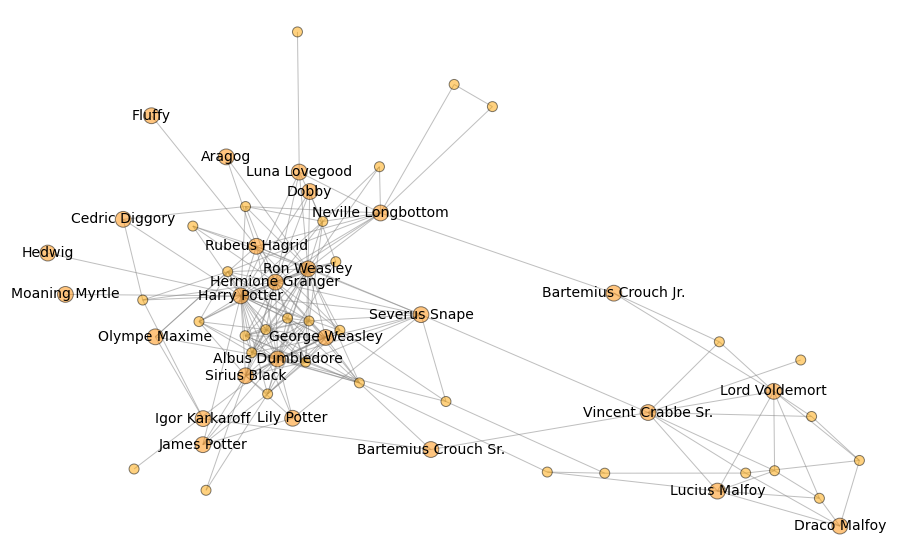

In [2]:
# Load the characters as the nodes of the graph
V = pd.read_csv(os.path.join("Data", "Harry Potter", "characters.csv")).drop("bio", axis=1)
V["name"] = [n.replace('"Barty" ', "") for n in V["name"]]
G = nx.Graph()
G.add_nodes_from([(v[0], {"name": v[1]}) for index, v in V.iterrows()])

# Load the relationships between the characters as the edges of the graph 
E = pd.read_csv(os.path.join("Data", "Harry Potter", "relations.csv"))
E = E.loc[E["type"] == "+", ["source", "target"]] # only include friendly relationships
G.add_edges_from([(e[0], e[1]) for index, e in E.iterrows()])

# Restrict to the largest connected component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
G0 = nx.relabel.convert_node_labels_to_integers(G0, first_label=0, ordering="default") # Reindex for embedding
print("Number of nodes: " + str(len(G0.nodes())))

# Choose some characters to highlight (here the same as in [1])
subV = ["Harry Potter", "Ron Weasley", "Hermione Granger", "Albus Dumbledore", "James Potter", "Lily Potter", 
        "Neville Longbottom", "Bartemius Crouch Jr.", "Lord Voldemort", "Lucius Malfoy", "Draco Malfoy", 
        "Bartemius Crouch Sr.", "Igor Karkaroff", "Olympe Maxime", "Fluffy", "Aragog", "Rubeus Hagrid", "Dobby", 
        "Cedric Diggory", "Sirius Black", "George Weasley", "Luna Lovegood", "Hedwig", "Moaning Myrtle", 
        "Severus Snape", "Vincent Crabbe Sr."]
node_labels = {n: G0.nodes()[n]["name"] for n in G0.nodes() if G0.nodes()[n]["name"] in subV}

# Obtain a layout for the graph (one may need to slightly shift some nodes for better visualizing the labels)
layout = nx.spring_layout(G0, seed=42)
layout[list(node_labels.keys())[list(node_labels.values()).index("Lord Voldemort")]] += 0.05
layout[list(node_labels.keys())[list(node_labels.values()).index("Ron Weasley")]] += 0.025
layout[list(node_labels.keys())[list(node_labels.values()).index("George Weasley")]] += 0.025
layout[list(node_labels.keys())[list(node_labels.values()).index("Severus Snape")]] += 0.075
layout[list(node_labels.keys())[list(node_labels.values()).index("James Potter")]] -= 0.05
layout[list(node_labels.keys())[list(node_labels.values()).index("Moaning Myrtle")]] += 0.05
layout[list(node_labels.keys())[list(node_labels.values()).index("Dobby")]] += 0.05

# Plot the graph
plt.figure(figsize=(16, 10)) 
node_size = [250 if n in node_labels.keys() else 100 for n in G0.nodes()]
node_color = ["darkorange" if n in node_labels.keys() else "orange" for n in G0.nodes()]
nodes = nx.draw_networkx_nodes(G0, layout, node_size=node_size, node_color=node_color, alpha=0.5)
nodes.set_edgecolor("black")
nx.draw_networkx_edges(G0, layout, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G0, layout, font_size=14, labels=node_labels)
plt.box(False)
plt.show()

## Define deepwalk embedding

Helper functions for conducting a deepwalk embedding are loaded from "topembed.py". We define the embedding function itself in this notebook. The function below can be used both with and without a topological loss.

In [3]:
def deepwalk(G, dim, top_criterion=None, top_frac=1, w=3, y=200, t=6, learning_rate=0.025, random_state=None):
    
    size_vertex = len(G.nodes())
    v = list(G.nodes())
    
    if not random_state is None:
        random.seed(random_state)
        np.random.seed(random_state)
        torch.manual_seed(random_state)
        
    model = HierarchicalModel(size_vertex=size_vertex, dim=dim)
    
    for i in range(y):
        random.shuffle(v)
    
        for vi in v:
            wvi = RandomWalk(G, vi, t)
            
            for j in range(len(wvi)):
                for k in range(max(0, j - w) , min(j + w, len(wvi))):
                    prob = model(wvi[j], wvi[k])
                    emb_loss = -torch.log(prob)
                    
                    if not top_criterion is None:
                        I = random.sample(range(size_vertex), int(size_vertex * top_frac)) \
                                if top_frac < 1 else range(size_vertex)
                        top_loss = top_criterion(model.phi[I,:])
                        loss = emb_loss + top_loss
                        loss.backward()
                        
                    else:
                        emb_loss.backward()

                    for param in model.parameters():
                        param.data.sub_(learning_rate * param.grad)
                        param.grad.data.zero_()
                        
        if i == 0 or (i + 1) % (int(y / 10)) == 0:
            if top_criterion is None:
                print ("[walks iter %d] [embedding loss: %f]" % (i + 1, emb_loss))
            else:
                print ("[walks iter %d] [embedding loss: %f, top loss: %f]" % (i + 1, emb_loss, top_loss))
                        
    return(model.phi.detach().numpy())

## View ordinary deepwalk embedding

We now obtain the ordinary deepwalk embedding of the Harry Potter network.

In [4]:
# Conduct deepwalk embedding
y = 50 # number of random walks per node
learning_rate = 1e-1

start_time = time.time()
phi = deepwalk(G0, dim=2, y=y, learning_rate=learning_rate, random_state=17)
elapsed_time = time.time() - start_time
print("Time for embedding: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

[walks iter 1] [embedding loss: 1.772680]
[walks iter 5] [embedding loss: 1.951165]
[walks iter 10] [embedding loss: 2.098699]
[walks iter 15] [embedding loss: 1.698697]
[walks iter 20] [embedding loss: 1.249441]
[walks iter 25] [embedding loss: 3.858939]
[walks iter 30] [embedding loss: 1.584080]
[walks iter 35] [embedding loss: 1.584813]
[walks iter 40] [embedding loss: 3.218186]
[walks iter 45] [embedding loss: 2.961007]
[walks iter 50] [embedding loss: 2.236513]
Time for embedding: 00:01:33


The deepwalk embedding, along with the circular model presented in [1], is now visualized as follows.

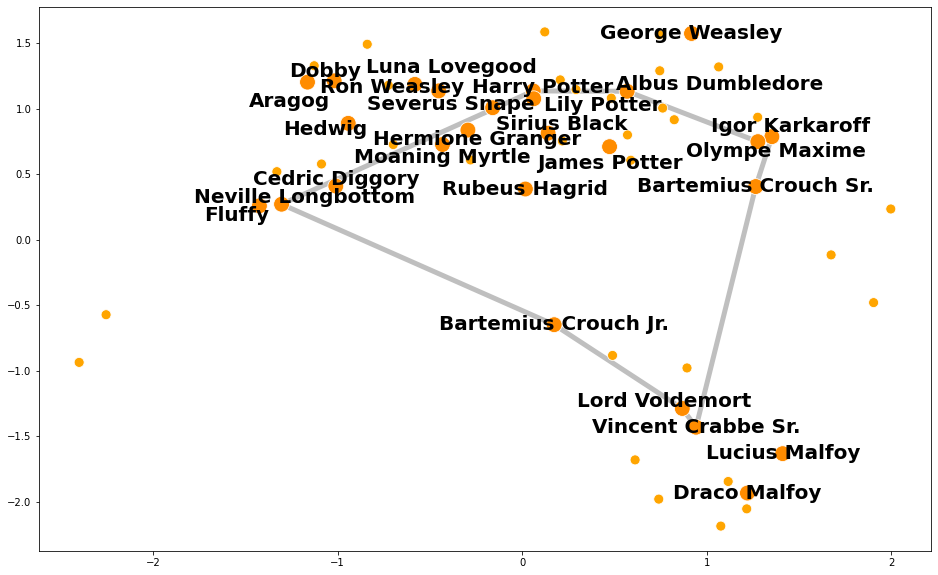

In [116]:
fig, ax = plt.subplots(figsize=(16, 10))

# Visualize circular model from [1]
circle = ["Harry Potter", "Neville Longbottom", "Bartemius Crouch Jr.", "Lord Voldemort", "Vincent Crabbe Sr.",
         "Bartemius Crouch Sr.", "Igor Karkaroff", "Olympe Maxime", "Albus Dumbledore"]
for idx in range(len(circle)):
    c1 = list(nx.get_node_attributes(G0, "name").values()).index(circle[idx])
    c2 = list(nx.get_node_attributes(G0, "name").values()).index(circle[(idx + 1) % len(circle)])
    plt.plot([phi[c1, 0], phi[c2, 0]], [phi[c1, 1], phi[c2, 1]], linewidth=5,
             c="grey", alpha=0.5, zorder=1)

# Plot the deepwalk embedding
sns.scatterplot(x=phi[:,0], y=phi[:,1], s=node_size, c=node_color, ax=ax, zorder=2)

# Visualize node labels
for key in node_labels.keys():
    x, y = phi[key, 0], phi[key, 1]
    if node_labels[key] in ["Luna Lovegood"]:
        x += 0.2
        y += 0.125
    if node_labels[key] in ["Dobby"]:
        x -= 0.05
        y += 0.075
    if node_labels[key] in ["James Potter"]:
        y -= 0.125
    if node_labels[key] in ["Aragog"]:
        x -= 0.05
        y -= 0.075
    if node_labels[key] in ["Aragog"]:
        x -= 0.05
        y -= 0.075
    if node_labels[key] in ["Olympe Maxime"]:
        x += 0.1
        y -= 0.075
    if node_labels[key] in ["Igor Karkaroff"]:
        x += 0.1
        y += 0.075
    if node_labels[key] in ["Lord Voldemort"]:
        x -= 0.1
        y += 0.05
    if node_labels[key] in ["Hermione Granger"]:
        x += 0.05
        y -= 0.075
    if node_labels[key] in ["Moaning Myrtle"]:
        y -= 0.1
    if node_labels[key] in ["Sirius Black"]:
        x += 0.075
        y += 0.065
    if node_labels[key] in ["Ron Weasley"]:
        x -= 0.25
        y += 0.025
    if node_labels[key] in ["Albus Dumbledore"]:
        y += 0.05
        x += 0.5
    if node_labels[key] in ["Harry Potter"]:
        x += 0.05
        y += 0.025
    if node_labels[key] in ["Severus Snape"]:
        x -= 0.225
        y += 0.025
    if node_labels[key] in ["Lily Potter"]:
        x += 0.375
        y -= 0.05
    if node_labels[key] in ["Hedwig"]:
        x -= 0.125
        y -= 0.05
    if node_labels[key] in ["Fluffy"]:
        x -= 0.125
        y -= 0.075
    if node_labels[key] in ["Neville Longbottom"]:
        x += 0.125
        y += 0.05
    if node_labels[key] in ["Cedric Diggory"]:
        y += 0.05
    plt.text(x, y, node_labels[key], verticalalignment="center", horizontalalignment="center", 
             size=20, weight="semibold")
    
plt.show()

## Apply topological regularization to the embedding

We now show how we can bias a graph embedding using a loss function that captures our topological prior. As a topological loss, we will use the persistence of the most prominent cycle in our embedding. It is important to multiply this by a factor $\lambda_{\mathrm{top}} <0$, since we want this persistence to be high. To obtain this loss, we require an additional layer that constructs the alpha complex from the embedding, from which subsequently persistent homology is computed.

In [6]:
# Define topological optimization

def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
top_layer = AlphaLayer(maxdim=1) # alpha complex layer
circular_persistence = DiagramFeature(dim=1, j=1, g=g) # compute persistence of most prominent cycle
lambda_top = -1e-2 # scalar factor that trades off embedding and topological loss

# Construct topological loss criterion

def top_criterion(output):
    
    dgminfo = top_layer(output)
    loss = lambda_top * circular_persistence(dgminfo)
    
    return loss

We can now conduct the topologically regularized graph embedding as follows.

In [7]:
# Conduct topological optimization
y = 50 # number of random walks per node
learning_rate = 1e-1

start_time = time.time()
phi_top = deepwalk(G0, dim=2, y=y, top_criterion=top_criterion, learning_rate=learning_rate, random_state=17)
elapsed_time = time.time() - start_time
print("Time for embedding: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

[walks iter 1] [embedding loss: 1.761819, top loss: -0.003625]
[walks iter 5] [embedding loss: 1.862919, top loss: -0.002852]
[walks iter 10] [embedding loss: 2.085949, top loss: -0.008242]
[walks iter 15] [embedding loss: 1.721571, top loss: -0.006797]
[walks iter 20] [embedding loss: 1.262757, top loss: -0.008720]
[walks iter 25] [embedding loss: 3.759151, top loss: -0.004451]
[walks iter 30] [embedding loss: 1.513260, top loss: -0.012713]
[walks iter 35] [embedding loss: 1.589229, top loss: -0.010420]
[walks iter 40] [embedding loss: 3.164859, top loss: -0.006730]
[walks iter 45] [embedding loss: 2.942257, top loss: -0.013913]
[walks iter 50] [embedding loss: 2.281459, top loss: -0.013536]
Time for embedding: 00:26:21


The topologically regularized deepwalk embedding, along with the circular model presented in [1], is now visualized as follows.

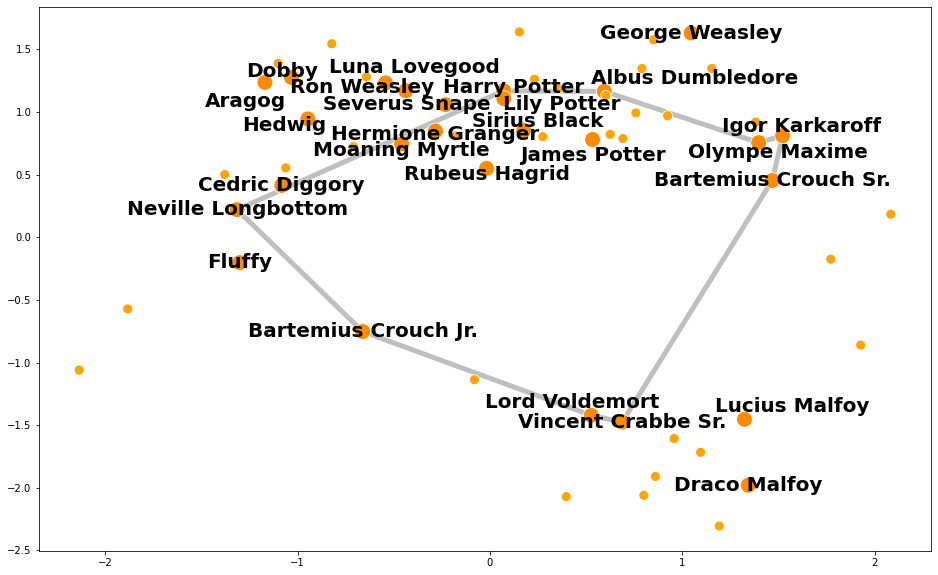

In [90]:
fig, ax = plt.subplots(figsize=(16, 10))

# Visualize the circular model from [1]
circle = ["Harry Potter", "Neville Longbottom", "Bartemius Crouch Jr.", "Lord Voldemort", "Vincent Crabbe Sr.",
         "Bartemius Crouch Sr.", "Igor Karkaroff", "Olympe Maxime", "Albus Dumbledore"]
for idx in range(len(circle)):
    c1 = list(nx.get_node_attributes(G0, "name").values()).index(circle[idx])
    c2 = list(nx.get_node_attributes(G0, "name").values()).index(circle[(idx + 1) % len(circle)])
    plt.plot([phi_top[c1, 0], phi_top[c2, 0]], [phi_top[c1, 1], phi_top[c2, 1]], linewidth=5,
             c="grey", alpha=0.5, zorder=1)

# Plot the deepwalk embedding
sns.scatterplot(x=phi_top[:,0], y=phi_top[:,1], s=node_size, c=node_color, ax=ax, zorder=2)

# Visualize the node labels
for key in node_labels.keys():
    x, y = phi_top[key, 0], phi_top[key, 1]
    if node_labels[key] in ["Luna Lovegood"]:
        x += 0.15
        y += 0.125
    if node_labels[key] in ["Dobby"]:
        x -= 0.05
        y += 0.05
    if node_labels[key] in ["Lucius Malfoy"]:
        x += 0.25
        y += 0.1
    if node_labels[key] in ["James Potter"]:
        y -= 0.125
    if node_labels[key] in ["Aragog"]:
        x -= 0.05
        y -= 0.075
    if node_labels[key] in ["Aragog"]:
        x -= 0.05
        y -= 0.075
    if node_labels[key] in ["Olympe Maxime"]:
        x += 0.1
        y -= 0.075
    if node_labels[key] in ["Igor Karkaroff"]:
        x += 0.1
        y += 0.075
    if node_labels[key] in ["Lord Voldemort"]:
        x -= 0.1
        y += 0.1
    if node_labels[key] in ["Hermione Granger"]:
        y -= 0.025
    if node_labels[key] in ["Moaning Myrtle"]:
        y -= 0.05
    if node_labels[key] in ["Rubeus Hagrid"]:
        y -= 0.05
    if node_labels[key] in ["Sirius Black"]:
        x += 0.075
        y += 0.075
    if node_labels[key] in ["Ron Weasley"]:
        x -= 0.225
        y += 0.025
    if node_labels[key] in ["Albus Dumbledore"]:
        y += 0.1
        x += 0.47
    if node_labels[key] in ["Harry Potter"]:
        x += 0.05
        y += 0.025
    if node_labels[key] in ["Severus Snape"]:
        x -= 0.2
    if node_labels[key] in ["Lily Potter"]:
        x += 0.3
        y -= 0.05
    if node_labels[key] in ["Hedwig"]:
        x -= 0.125
        y -= 0.05
    plt.text(x, y, node_labels[key], verticalalignment="center", horizontalalignment="center", 
             size=20, weight="semibold")
    
plt.show()